In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import torch
import torch.nn as nn

# 加载CSV文件
data = pd.read_csv('/Users/curryyang/code/2024_MCM_C_UESTC/processed_datasets/male_processed.csv')  # 确保这里的路径是正确的

# 提取指定行的数据
rows_to_use = list(range(1, 302)) + list(range(3790, 4015)) + list(range(5709, 5898)) + list(range(6591, 6750))
rows_to_use_1 = list(range(3623, 3789)) + list(range(5438, 5708)) + list(range(6374, 6590)) + list(range(6750, 6951))
train_data = data.iloc[rows_to_use]
train_data_1 = data.iloc[rows_to_use_1]

# 测试集 - 最后一场比赛的数据
test_data = data.iloc[6952:7286]

# 预处理p1_score，将"AD"替换为40
train_data['p1_score'] = train_data['p1_score'].replace('AD', 40).astype(int)
test_data['p1_score'] = test_data['p1_score'].replace('AD', 40).astype(int)
train_data_1['p2_score'] = train_data_1['p2_score'].replace('AD', 40).astype(int)
test_data['p2_score'] = test_data['p2_score'].replace('AD', 40).astype(int)
# 提取p1_score作为训练和测试数据
train_scores = train_data['p1_score'].values
test_scores = test_data['p1_score'].values

# 提取p2_score作为训练和测试数据
train_scores_1 = train_data_1['p2_score'].values
test_scores_1 = test_data['p2_score'].values

# 数据归一化
scaler = MinMaxScaler(feature_range=(-1, 1))
train_scores_normalized = scaler.fit_transform(train_scores.reshape(-1, 1))
test_scores_normalized = scaler.transform(test_scores.reshape(-1, 1))
# 数据归一化plaer2
scaler = MinMaxScaler(feature_range=(-1, 1))
train_scores_normalized_1 = scaler.fit_transform(train_scores_1.reshape(-1, 1))
test_scores_normalized_1 = scaler.transform(test_scores_1.reshape(-1, 1))
# 转换为PyTorch张量
train_scores_normalized = torch.FloatTensor(train_scores_normalized).view(-1)
test_scores_normalized = torch.FloatTensor(test_scores_normalized).view(-1)
# 转换为PyTorch张量player2
train_scores_normalized_1 = torch.FloatTensor(train_scores_normalized_1).view(-1)
test_scores_normalized_1 = torch.FloatTensor(test_scores_normalized_1).view(-1)


/var/folders/s0/_m13xvgj0y9_pg386fxb3g5w0000gn/T/ipykernel_23107/2688519852.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/var/folders/s0/_m13xvgj0y9_pg386fxb3g5w0000gn/T/ipykernel_23107/2688519852.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['p1_score'] = train_data['p1_score'].replace('AD', 40).astype(int)
/var/folders/s0/_m13xvgj0y

In [3]:
class CNNLSTMModel(nn.Module):
    def __init__(self, hidden_layer_size=50):
        super(CNNLSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size  # 添加hidden_layer_size属性
        
        # 定义模型层
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        self.lstm = nn.LSTM(input_size=64, hidden_size=self.hidden_layer_size, num_layers=1, batch_first=True)
        self.linear = nn.Linear(in_features=self.hidden_layer_size, out_features=1)

    def forward(self, x):
        #x = x.unsqueeze(1)  # 添加channel维度
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.transpose(1, 2)  # 调整维度以适应LSTM的输入要求
        lstm_out, _ = self.lstm(x)
        predictions = self.linear(lstm_out[:, -1, :])  # 只使用序列的最后一个输出
        return predictions


In [4]:
# 定义训练数据加载器
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq, train_label))
    return inout_seq

# 设定时间窗口大小
train_window = 5
test_window = 5

# 创建训练序列
train_inout_seq = create_inout_sequences(train_scores_normalized, train_window)
test_inout_seq = create_inout_sequences(test_scores_normalized, test_window)
# 创建训练序列player2
train_inout_seq_1 = create_inout_sequences(train_scores_normalized_1, train_window)
test_inout_seq_1 = create_inout_sequences(test_scores_normalized_1, test_window)



In [5]:
def train_model(model, train_inout_seq, epochs=10, lr=0.001):
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    losses = []  # 用于收集每个epoch的损失值

    for epoch in range(epochs):
        total_loss = 0
        for seq, labels in train_inout_seq:
            optimizer.zero_grad()
            seq = seq.view(-1, 1, train_window)
            y_pred = model(seq)
            single_loss = loss_function(y_pred, labels)
            single_loss.backward()
            optimizer.step()
            total_loss += single_loss.item()
        
        avg_loss = total_loss / len(train_inout_seq)
        losses.append(avg_loss)
        print(f'epoch: {epoch+1} loss: {avg_loss:.8f}')
    
    return losses


/Users/curryyang/anaconda3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch: 1 loss: 0.52776132
epoch: 2 loss: 0.46258668
epoch: 3 loss: 0.44771589
epoch: 4 loss: 0.44086501
epoch: 5 loss: 0.43600849
epoch: 6 loss: 0.43213087
epoch: 7 loss: 0.42875463
epoch: 8 loss: 0.42576706
epoch: 9 loss: 0.42307538
epoch: 10 loss: 0.42052392
epoch: 11 loss: 0.41806152
epoch: 12 loss: 0.41552833
epoch: 13 loss: 0.41303666
epoch: 14 loss: 0.41053370
epoch: 15 loss: 0.40808607
epoch: 16 loss: 0.40589411
epoch: 17 loss: 0.40402143
epoch: 18 loss: 0.40243151
epoch: 19 loss: 0.40100163
epoch: 20 loss: 0.39983439
epoch: 21 loss: 0.39873541
epoch: 22 loss: 0.39775438
epoch: 23 loss: 0.39679755
epoch: 24 loss: 0.39580070
epoch: 25 loss: 0.39489886
epoch: 26 loss: 0.39400880
epoch: 27 loss: 0.39314717
epoch: 28 loss: 0.39231220
epoch: 29 loss: 0.39145256
epoch: 30 loss: 0.39062469
epoch: 31 loss: 0.38987842
epoch: 32 loss: 0.38913969
epoch: 33 loss: 0.38845940
epoch: 34 loss: 0.38789329
epoch: 35 loss: 0.38729944
epoch: 36 loss: 0.38675686
epoch: 37 loss: 0.38618915
epoch: 38 

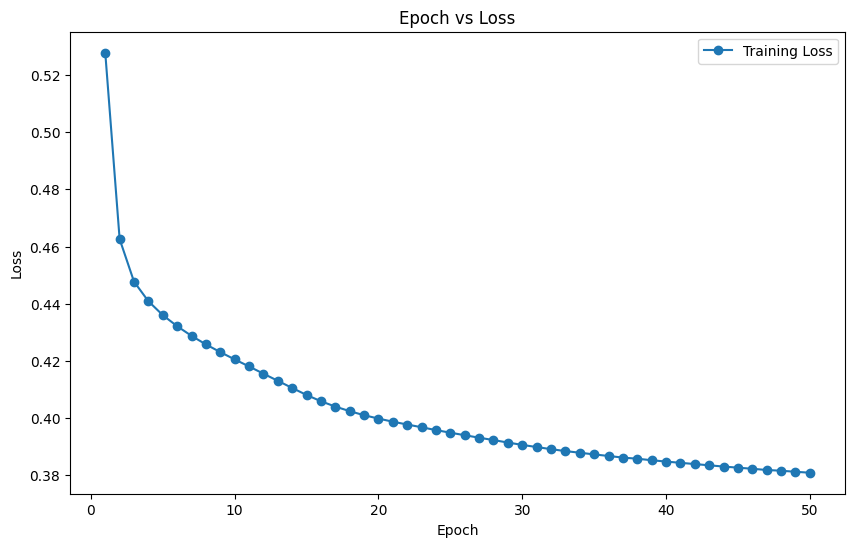

In [6]:
import matplotlib.pyplot as plt

# 实例化并训练模型
model = CNNLSTMModel()
losses = train_model(model, train_inout_seq, epochs=50, lr=0.001)

# 绘制训练损失曲线
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(losses)+1), losses, marker='o', label='Training Loss')
plt.title('Epoch vs Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


epoch: 1 loss: 0.52977824
epoch: 2 loss: 0.43967647
epoch: 3 loss: 0.40991248
epoch: 4 loss: 0.39525693
epoch: 5 loss: 0.38610895
epoch: 6 loss: 0.37943859
epoch: 7 loss: 0.37430744
epoch: 8 loss: 0.36993092
epoch: 9 loss: 0.36611257
epoch: 10 loss: 0.36266262
epoch: 11 loss: 0.35950356
epoch: 12 loss: 0.35679930
epoch: 13 loss: 0.35430671
epoch: 14 loss: 0.35201737
epoch: 15 loss: 0.35009021
epoch: 16 loss: 0.34825482
epoch: 17 loss: 0.34662988
epoch: 18 loss: 0.34513449
epoch: 19 loss: 0.34382821
epoch: 20 loss: 0.34259264
epoch: 21 loss: 0.34132420
epoch: 22 loss: 0.34040914
epoch: 23 loss: 0.33952204
epoch: 24 loss: 0.33876936
epoch: 25 loss: 0.33809274
epoch: 26 loss: 0.33742772
epoch: 27 loss: 0.33683218
epoch: 28 loss: 0.33624634
epoch: 29 loss: 0.33575179
epoch: 30 loss: 0.33528838
epoch: 31 loss: 0.33493248
epoch: 32 loss: 0.33460222
epoch: 33 loss: 0.33416887
epoch: 34 loss: 0.33388388
epoch: 35 loss: 0.33359834
epoch: 36 loss: 0.33334962
epoch: 37 loss: 0.33308993
epoch: 38 

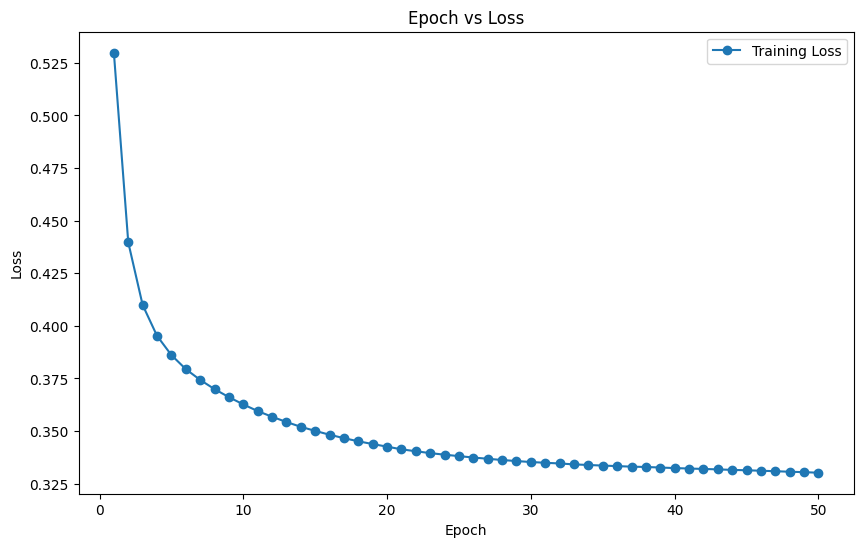

In [7]:
# 实例化并训练模型player2
import matplotlib.pyplot as plt

# 实例化并训练模型
model_1 = CNNLSTMModel()
losses_1 = train_model(model_1, train_inout_seq_1, epochs=50, lr=0.001)

# 绘制训练损失曲线
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(losses_1)+1), losses_1, marker='o', label='Training Loss')
plt.title('Epoch vs Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

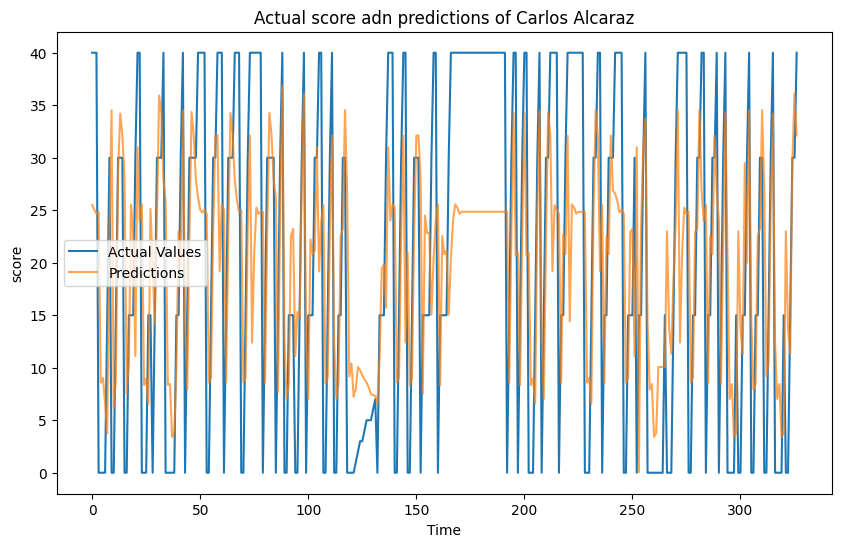

In [11]:
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for seq, true_val in test_inout_seq:  # 确保test_inout_seq已准备好
        seq = seq.view(-1, 1, train_window)
        prediction = model(seq)
        prediction = scaler.inverse_transform(prediction.numpy().reshape(-1, 1))
        true_val = scaler.inverse_transform(true_val.numpy().reshape(-1, 1))

        # 检查prediction是否包含多个值
        if prediction.size > 1:
            predictions.extend(prediction.squeeze().tolist())
        else:
            predictions.append(prediction.item())  # 直接添加单个预测值

        # 对于实际值执行相同的检查
        if true_val.size > 1:
            actuals.extend(true_val.squeeze().tolist())
        else:
            actuals.append(true_val.item())

# 绘制测试集拟合曲线
plt.figure(figsize=(10, 6))
plt.plot(actuals, label='Actual Values')
plt.plot(predictions, label='Predictions', alpha=0.7)
plt.title('Actual score adn predictions of Carlos Alcaraz')
plt.xlabel('Time')
plt.ylabel('score')
plt.legend()
plt.show()


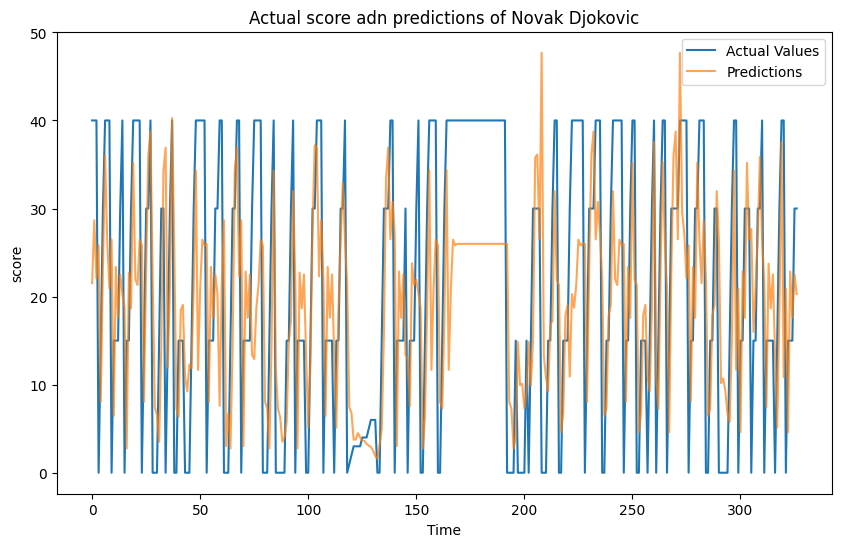

In [12]:
model_1.eval()
predictions_1 = []
actuals_1 = []

with torch.no_grad():
    for seq, true_val in test_inout_seq_1:  # 确保test_inout_seq已准备好
        seq = seq.view(-1, 1, train_window)
        prediction = model_1(seq)
        prediction = scaler.inverse_transform(prediction.numpy().reshape(-1, 1))
        true_val = scaler.inverse_transform(true_val.numpy().reshape(-1, 1))

        # 检查prediction是否包含多个值
        if prediction.size > 1:
            predictions_1.extend(prediction.squeeze().tolist())
        else:
            predictions_1.append(prediction.item())  # 直接添加单个预测值

        # 对于实际值执行相同的检查
        if true_val.size > 1:
            actuals_1.extend(true_val.squeeze().tolist())
        else:
            actuals_1.append(true_val.item())

# 绘制测试集拟合曲线
plt.figure(figsize=(10, 6))
plt.plot(actuals_1, label='Actual Values')
plt.plot(predictions_1, label='Predictions', alpha=0.7)
plt.title('Actual score adn predictions of Novak Djokovic')
plt.xlabel('Time')
plt.ylabel('score')
plt.legend()
plt.show()


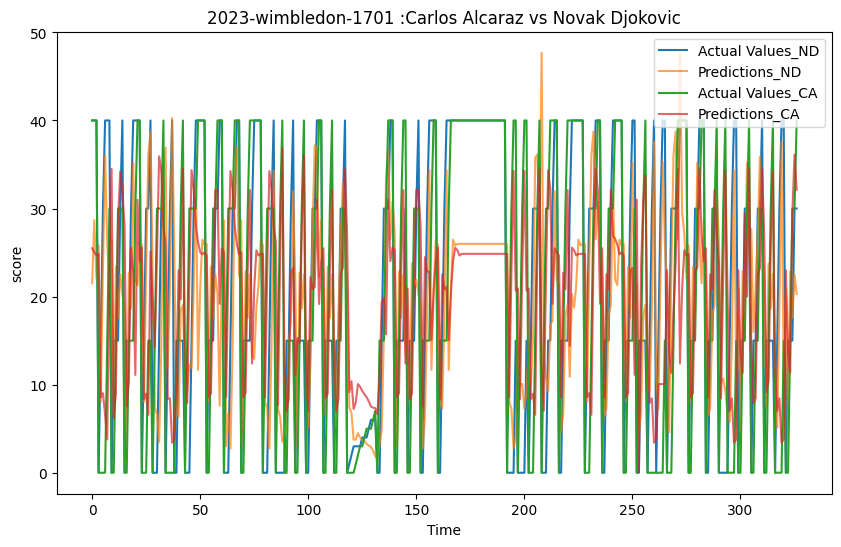

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(actuals_1, label='Actual Values_ND')
plt.plot(predictions_1, label='Predictions_ND', alpha=0.7)
plt.plot(actuals, label='Actual Values_CA')
plt.plot(predictions, label='Predictions_CA', alpha=0.7)
plt.title('2023-wimbledon-1701 :Carlos Alcaraz vs Novak Djokovic')
plt.xlabel('Time')
plt.ylabel('score')
plt.legend()
plt.show()